In [3]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [4]:
import torch
from torch import nn
import torchvision
from torchvision import tv_tensors
from torchvision.transforms import v2

import numpy as np
import matplotlib.pyplot as plt

import os
import PIL
from PIL import Image

In [5]:
import sys

LIB_PATH = '/kaggle/input/od-helper'
sys.path.append(LIB_PATH)

from OD_datasets_kaggle import VOCDetection, OD_transform
from OD_utils import visualize
import S4T as S

In [6]:
train_augs = v2.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomPhotometricDistort(p = 0.5),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_augs = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_transform = OD_transform(500, None, None, train_augs)
test_transform = OD_transform(500, None, None, test_augs)

In [7]:
from typing import Optional, Callable, Tuple, List

class PascalVOC2012(S.SDataModule):
    def __init__(self,
                 train_transforms: Optional[Callable],
                 test_transforms: Optional[Callable],
                 batch_size: int):
        super().__init__()
        self.batch_size = batch_size
        train2007 = VOCDetection('/kaggle/input/voc0712/VOC_dataset/VOCdevkit/VOC2007', image_set = 'train', transforms = train_transforms)
        train2012 = VOCDetection('/kaggle/input/voc0712/VOC_dataset/VOCdevkit/VOC2012', image_set = 'train', transforms = train_transforms)
        self.train_dataset = torch.utils.data.ConcatDataset([train2007, train2012])
        self.val_dataset = VOCDetection('/kaggle/input/voc0712/VOC_dataset/VOCdevkit/VOC2012', image_set = 'val', transforms = test_transforms)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset,
                                           batch_size = self.batch_size,
                                           shuffle = True,
                                           collate_fn = self.collate_fn,
                                           num_workers = 4,
                                           prefetch_factor = 1)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset,
                                           batch_size = self.batch_size,
                                           shuffle = False,
                                           collate_fn = self.collate_fn,
                                           num_workers = 4,
                                           prefetch_factor = 1)

    def collate_fn(self, batch):
        img_batch, tar_batch = [], []
        for img, tar in batch:
            img_batch.append(img)
            tar_batch.append(tar)
        return torch.stack(img_batch), tar_batch

In [8]:
data = PascalVOC2012(train_transforms = train_transform,
                     test_transforms = test_transform,
                     batch_size = 32)

In [9]:
class AnchorGenerator:
    def __init__(self,
                 heights: list,
                 widths: list):
        self.heights = heights
        self.widths = widths
    
    def __call__(self, 
                 upper_lefts: torch.Tensor,
                 grid_cell_h: float,
                 grid_cell_w: float,
                 device: str = 'cpu'):
        """
        Returns: (cxcywh)
        """
        return torch.tensor([[upper_lefts[0] + grid_cell_w/2]*len(self.widths), 
                             [upper_lefts[1] + grid_cell_h/2]*len(self.heights), 
                             self.widths, self.widths], device = device).T

class Matcher:
    def __init__(self, 
                 threshold: int = 0.5):
        self.threshold = threshold
    
    def __call__(self, 
                 match_quality_matrix: torch.Tensor):
        """
        Inputs:
            match_quality_matrix: torch.Tensor. 
                Should have shape (N, M) in there N, M are the number of ground-truth bounding box and anchor boxes respectively

        Outputs:
            Anchors_bbox_map: torch.Tensor: anchors are with no grouth-truth match will be labeled -1
        """
        num_gt_bbox, num_anchors = match_quality_matrix.shape
        jaccard = match_quality_matrix.clone()

        max_iou_anchor_values, anchors_bbox_map = torch.max(jaccard, dim = 0)
        anchors_bbox_map[max_iou_anchor_values<self.threshold] = -1
        for _ in range(num_gt_bbox):
            max_idx = torch.argmax(jaccard)
            anchors_bbox_map[max_idx%num_anchors] = max_idx//num_anchors
            jaccard[:, max_idx%num_anchors] = -1
            jaccard[max_idx//num_anchors, :] = -1
        return anchors_bbox_map

class OffsetCoder:
    def __init__(self, 
                 weights: List[int],
                 eps: float = 1e-6):
        self.weights = weights
        self.eps = eps

    def decode(self,
               encoded_offsets: torch.Tensor,
               anchors: torch.Tensor,
               grid_cell_h: float,
               grid_cell_w: float):
        """
        """
        gridcells = anchors[:, :2] - torch.tensor([grid_cell_w/2, grid_cell_w/2], device = anchors.device)
        bboxes = torch.zeros_like(encoded_offsets, device = anchors.device)
        bboxes[:, 0] = encoded_offsets[:, 0]*grid_cell_w/self.weights[0] + gridcells[:, 0]
        bboxes[:, 1] = encoded_offsets[:, 1]*grid_cell_h/self.weights[1] + gridcells[:, 1]
        bboxes[:, 2] = torch.exp(encoded_offsets[:, 2]/self.weights[2])*anchors[:, 2]
        bboxes[:, 3] = torch.exp(encoded_offsets[:, 3]/self.weights[3])*anchors[:, 3]
        return bboxes

    def encode(self,
               boxes: torch.Tensor,
               anchors: torch.Tensor,
               grid_cell_h: float,
               grid_cell_w: float):
        """
        """
        gridcells = anchors[:, :2] - torch.tensor([grid_cell_w/2, grid_cell_h/2], device = anchors.device)
        bboxes = torch.zeros_like(boxes, device = anchors.device)
        bboxes[:, 0] = self.weights[0]*(boxes[:, 0]-gridcells[:, 0])/grid_cell_w
        bboxes[:, 1] = self.weights[1]*(boxes[:, 1]-gridcells[:, 1])/grid_cell_h
        bboxes[:, 2] = self.weights[2]*(torch.log(boxes[:, 2]/anchors[:, 2] + self.eps))
        bboxes[:, 3] = self.weights[3]*(torch.log(boxes[:, 3]/anchors[:, 3] + self.eps))
        return bboxes

def box_iou(boxes1: torch.Tensor,
            boxes2: torch.Tensor,
            box_type: str):
    if box_type == 'cxcywh':
            boxes1 = torchvision.ops.box_convert(boxes1, 'cxcywh', 'xyxy')
            boxes2 = torchvision.ops.box_convert(boxes2, 'cxcywh', 'xyxy')
    return torchvision.ops.box_iou(boxes1, boxes2)

class Resnet18(nn.Module):
    def __init__(self,
                 pretrained: bool = True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.net = torchvision.models.resnet18(pretrained)
        delattr(self.net, "avgpool")
        delattr(self.net, "fc")
    def forward(self, X: torch.Tensor):
        return self.net.layer4(self.net.layer3(self.net.layer2(self.net.layer1(self.net.maxpool(self.net.relu(self.net.bn1(self.net.conv1(X))))))))

In [10]:
class MyYOLO_ResNet18(S.SModule):
    def __init__(self,
                 grid_size: Tuple[int, int],
                 num_classes: int,
                 anchor_size: List[list],
                 iou_thres: float,
                 lr: float,
                 image_size: Optional[tuple] = None):
        super().__init__()
        self.num_classes = num_classes
        self.num_boxes_per_gridcell = len(anchor_size[0])
        self.grid_size = grid_size
        self.image_size = image_size
        self.lr = lr
        self.anchor_generator = AnchorGenerator(heights = anchor_size[0],
                                                widths = anchor_size[1])
        self.proposal_matcher = Matcher(iou_thres)
        self.box_coder = OffsetCoder(weights = (1, 1, 1, 1))
        self.backbone = Resnet18(True)
        self.predictor = nn.Conv2d(512, self.num_boxes_per_gridcell*(5 + num_classes),
                                   kernel_size = 3, padding = 1)

    def forward(self, X: torch.Tensor):
        out = self.backbone(X)
        out = self.predictor(out).permute(0, 2, 3, 1)
        return out.reshape(out.shape[0], out.shape[1], out.shape[2], self.num_boxes_per_gridcell, -1)

In [11]:
import collections

@add_to_class(MyYOLO_ResNet18)
def loss(self,
         preds: torch.Tensor,
         targets: List[dict]):
    grid_cell_h, grid_cell_w = self.image_size[0]/self.grid_size[0], \
                               self.image_size[1]/self.grid_size[1]

    num_foreground = 0
    local_loss = 0
    obj_conf_loss = 0
    noobj_conf_loss = 0
    prob_loss = 0
    total_iou = 0
    for preds_per_img, targets_per_img in zip(preds, targets):                                   # (S, S, B, 5+C) vs (m, )
        if targets_per_img['boxes'].numel() == 0:
            continue
        shuffle_idxs = torch.randperm(targets_per_img['boxes'].shape[0])
        gt_bboxes_per_img = torchvision.ops.box_convert(targets_per_img['boxes'], 'xyxy', 'cxcywh')[shuffle_idxs]                         # (m, 4)
        gt_logits_per_img = nn.functional.one_hot(targets_per_img['labels']-1, self.num_classes).type(torch.float)[shuffle_idxs]          # (m, C)

        foreground_gc_idxs_per_img = gt_bboxes_per_img[:, :2].clone()
        foreground_gc_idxs_per_img[:, 0] = foreground_gc_idxs_per_img[:, 0]//grid_cell_w
        foreground_gc_idxs_per_img[:, 1] = foreground_gc_idxs_per_img[:, 1]//grid_cell_h
        foreground_gc_idxs_per_img = foreground_gc_idxs_per_img.type(torch.long)

        foreground_gc_matched_idxs = collections.defaultdict(list)
        for idx, fg_gc_idx in enumerate(foreground_gc_idxs_per_img):
            foreground_gc_matched_idxs[(fg_gc_idx[1].item(), fg_gc_idx[0].item())].append(idx)
        foreground_gc_matched_idxs = collections.OrderedDict(sorted(foreground_gc_matched_idxs.items()))

        matched_idxs_per_img = torch.full((self.grid_size[0], self.grid_size[1], self.num_boxes_per_gridcell), -1,
                                          dtype = torch.int64, device = preds.device)                     # (S, S, B)
        assigned_anchors_per_img = []
        for gc_idx, matched_per_gc in foreground_gc_matched_idxs.items():
            anchors = self.anchor_generator((gc_idx[1]*grid_cell_w, gc_idx[0]*grid_cell_h),
                                            grid_cell_h,
                                            grid_cell_w,
                                            device = preds.device)
            matched_per_gc = torch.tensor(matched_per_gc, device = preds.device)
            mqmat_per_gc = box_iou(gt_bboxes_per_img[matched_per_gc], anchors, box_type = 'cxcywh')
            fg_idxs_per_gc = self.proposal_matcher(mqmat_per_gc)
            matched_idxs_per_gc = fg_idxs_per_gc[fg_idxs_per_gc>=0]
            matched_idxs_per_img[gc_idx[0], gc_idx[1]][fg_idxs_per_gc>=0] = matched_per_gc[matched_idxs_per_gc]
            assigned_anchors_per_img.append(anchors[fg_idxs_per_gc>=0])
        assigned_anchors_per_img = torch.concat(assigned_anchors_per_img, dim = 0)                         # (objs, 4)

        foreground_preds_per_img = preds_per_img[matched_idxs_per_img >= 0]                                # (objs, 5+C)
        background_preds_per_img = preds_per_img[matched_idxs_per_img < 0]                                 # (noobjs, 5+C)
        gt_matched_idxes_per_img = matched_idxs_per_img[matched_idxs_per_img >= 0]
        num_foreground += len(gt_matched_idxes_per_img)

        # noobjs
        #noobj_conf_loss += (torch.sigmoid(background_preds_per_img[:, 0]).reshape(-1)**2).sum()
        noobj_conf_loss += nn.functional.binary_cross_entropy(torch.sigmoid(background_preds_per_img[:, 0]).reshape(-1),
                                                              torch.tensor([0]*len(background_preds_per_img)).to(preds), reduction = 'sum')
        # objs
        conf_obj_preds_per_img = torch.sigmoid(foreground_preds_per_img[:, 0])                              # (objs, 1)
        offset_preds_per_img = foreground_preds_per_img[:, 1:  5]                                           # (objs, 4)
        offset_preds_per_img[:, :2] = torch.sigmoid(offset_preds_per_img[:, :2])
        #prob_preds_per_img = torch.sigmoid(foreground_preds_per_img[:, -self.num_classes:])                 # (objs, C)
        prob_preds_per_img = foreground_preds_per_img[:, -self.num_classes:]                 # (objs, C)
        ## prob_loss
        prob_loss += nn.functional.cross_entropy(prob_preds_per_img,
                                                 gt_logits_per_img[gt_matched_idxes_per_img], reduction = 'sum')
        # compute iou
        predicted_boxes_per_img = self.box_coder.decode(offset_preds_per_img,
                                                        assigned_anchors_per_img,
                                                        grid_cell_h, grid_cell_w)
        total_iou += torch.diag(box_iou(gt_bboxes_per_img[gt_matched_idxes_per_img],
                                predicted_boxes_per_img, box_type = 'cxcywh')).sum()
        ## local_loss
        gt_offsets_per_img = self.box_coder.encode(gt_bboxes_per_img[gt_matched_idxes_per_img],
                                                   assigned_anchors_per_img,
                                                   grid_cell_h, grid_cell_w)
        local_loss += nn.functional.smooth_l1_loss(offset_preds_per_img[:, :2], gt_offsets_per_img[:, :2], reduction = 'sum')\
                    + nn.functional.smooth_l1_loss(offset_preds_per_img[:, 2:], gt_offsets_per_img[:, 2:], reduction = 'sum')
        ## obj_conf_loss
        obj_conf_loss += nn.functional.binary_cross_entropy(conf_obj_preds_per_img.reshape(-1),
                                                            torch.Tensor([1]*len(conf_obj_preds_per_img)).to(preds), reduction = 'sum')

    N = max(1, num_foreground)
    return local_loss/N, prob_loss/N, obj_conf_loss/N, noobj_conf_loss/N, total_iou/N

In [12]:
@add_to_class(MyYOLO_ResNet18)
def training_step(self, batch, batch_idx):
    x, y = batch
    preds = self.forward(x)
    local_loss, prob_loss, obj_conf_loss, noobj_conf_loss, avg_iou = self.loss(preds, y)
    loss = local_loss + prob_loss + obj_conf_loss + noobj_conf_loss
    values = {"train_loss": loss,
              "train_local_los": local_loss,
              "train_prob_loss": prob_loss,
              "train_obj_conf_loss": obj_conf_loss,
              "train_noobj_conf_loss": noobj_conf_loss,
              "train_avg_iou": avg_iou}
    self.log_dict(values, pbar = True, train_logging = True)
    return loss

@add_to_class(MyYOLO_ResNet18)
def validation_step(self, batch, batch_idx):
    x, y = batch
    preds = self.forward(x)
    local_loss, prob_loss, obj_conf_loss, noobj_conf_loss, avg_iou = self.loss(preds, y)
    loss = local_loss + prob_loss + obj_conf_loss + noobj_conf_loss
    values = {"val_loss": loss,
              "val_local_los": local_loss,
              "val_prob_loss": prob_loss,
              "val_obj_conf_loss": obj_conf_loss,
              "val_noobj_conf_loss": noobj_conf_loss,
              "val_avg_iou": avg_iou}    
    self.log_dict(values, pbar = True, train_logging = False)

@add_to_class(MyYOLO_ResNet18)
def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr = self.lr, weight_decay = 0.00005)
    return optimizer

In [13]:
checkpoint_callback = S.ModelCheckpoint(dirpath = '/kaggle/working',
                                      save_top_k = 7, monitor = 'val_loss',
                                      mode = 'min',
                                      filename = 'mYOLO2-voc-12-epoch:%02d-val_loss:%.4f')

In [14]:
torch.manual_seed(42)

net = MyYOLO_ResNet18(grid_size = (16, 16),
                      num_classes = 20,
                      anchor_size = [[135.7643, 257.4366, 379.2922, 236.0847,  54.3663],
                                     [127.8012, 173.5446, 302.6718, 414.0100,  43.1354]],
                      iou_thres = 0.6,
                      image_size = (500, 500),
                      lr = 1e-3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s] 


In [ ]:
print('Start training')

trainer = S.Trainer(accelerator="gpu",
                    callbacks = [checkpoint_callback],
                    enable_checkpointing=True,
                    max_epochs = 60)
trainer.fit(net, data, ckpt_path = '/kaggle/input/yolov2-ckpt/mYOLO2-voc-12-epoch_39-val_loss_5.2890.ckpt')

## Inference

In [78]:
ckpt = torch.load('/kaggle/input/yolov2-ckpt/mYOLO2-voc-12-epoch_47-val_loss_5.5666.ckpt',  map_location = torch.device('cpu'))['state_dict']
net.load_state_dict(ckpt)

<All keys matched successfully>

In [79]:
net = net.cpu()

In [21]:
val_dataset = data.val_dataset

torch.uint8


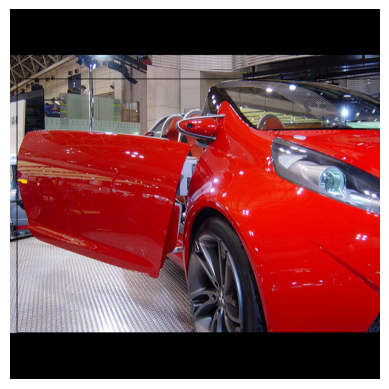

In [44]:
visualize(val_dataset[7][0], val_dataset[7][1]['boxes'], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [45]:
net.eval()
preds = net(val_dataset[7][0].unsqueeze(0))
preds.shape

torch.Size([1, 16, 16, 5, 25])

In [46]:
conf_preds = torch.sigmoid(preds[:, :, :, :, 0])
print(conf_preds.shape)
offset_preds = preds[:, :, :, :, 1:5]
print(offset_preds.shape)
prob_preds = torch.softmax(preds[:, :, :, :, 5:], dim = -1)
print(prob_preds.shape)

torch.Size([1, 16, 16, 5])
torch.Size([1, 16, 16, 5, 4])
torch.Size([1, 16, 16, 5, 20])


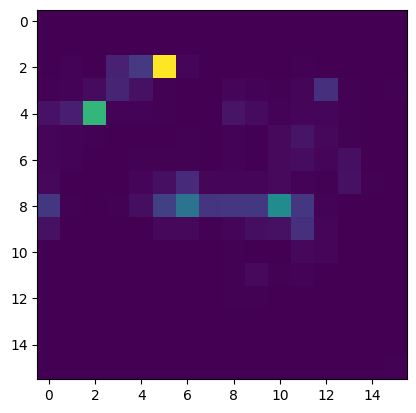

In [47]:
max_conf_preds, max_conf_pred_idxs = torch.max(conf_preds, dim = -1)
plt.imshow(max_conf_preds.squeeze(0).detach().numpy())

In [48]:
max_conf_preds.max()

tensor(0.5825, grad_fn=<MaxBackward1>)

In [49]:
prob_preds[:, torch.arange(0, 16), torch.arange(0, 16), max_conf_pred_idxs.squeeze()].shape

torch.Size([1, 16, 16, 20])

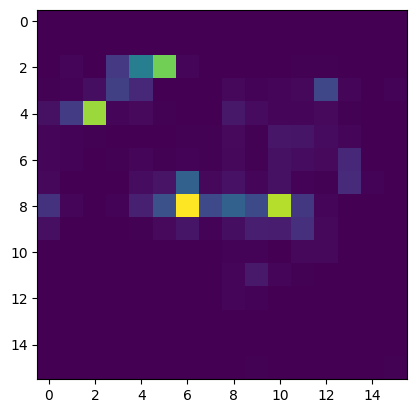

In [50]:
post_prob = max_conf_preds.unsqueeze(3)*prob_preds[:, torch.arange(0, 16), torch.arange(0, 16), max_conf_pred_idxs.squeeze()]
max_post_prob = torch.max(post_prob, dim = -1)[0]
plt.imshow(max_post_prob.squeeze(0).detach().numpy())

In [51]:
post_prob.max()

tensor(0.1980, grad_fn=<MaxBackward1>)

In [23]:
argmax_post_prob = torch.argmax(post_prob, dim = -1)
argmax_post_prob[:, 8, 10]

tensor([6])

torch.uint8


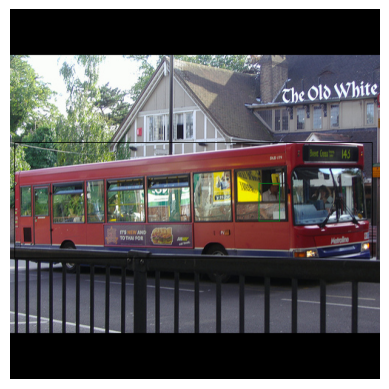

In [52]:
visualize(val_dataset[8][0], val_dataset[8][1]['boxes'], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [53]:
net.eval()
preds = net(val_dataset[8][0].unsqueeze(0))
preds.shape

torch.Size([1, 16, 16, 5, 25])

In [54]:
conf_preds = torch.sigmoid(preds[:, :, :, :, 0])
print(conf_preds.shape)
offset_preds = preds[:, :, :, :, 1:5]
print(offset_preds.shape)
prob_preds = torch.softmax(preds[:, :, :, :, 5:], dim = -1)
print(prob_preds.shape)

torch.Size([1, 16, 16, 5])
torch.Size([1, 16, 16, 5, 4])
torch.Size([1, 16, 16, 5, 20])


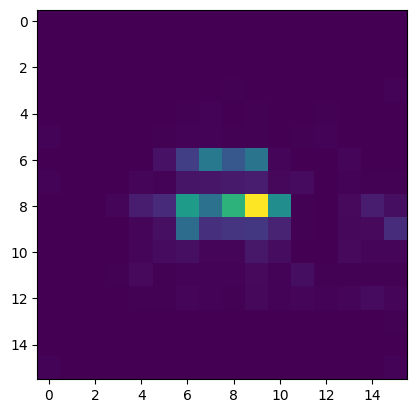

In [55]:
max_conf_preds, max_conf_pred_idxs = torch.max(conf_preds, dim = -1)
plt.imshow(max_conf_preds.squeeze(0).detach().numpy())

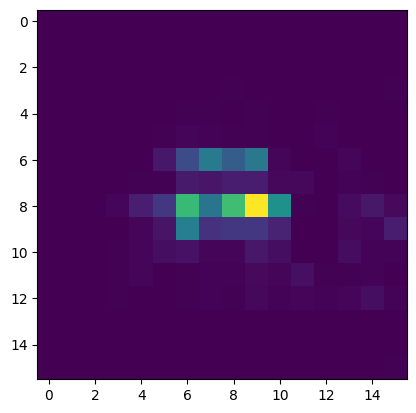

In [56]:
post_prob = max_conf_preds.unsqueeze(3)*prob_preds[:, torch.arange(0, 16), torch.arange(0, 16), max_conf_pred_idxs.squeeze()]
max_post_prob = torch.max(post_prob, dim = -1)[0]
plt.imshow(max_post_prob.squeeze(0).detach().numpy())

In [57]:
post_prob.max()

tensor(0.4727, grad_fn=<MaxBackward1>)

In [58]:
argmax_post_prob = torch.argmax(post_prob, dim = -1)
argmax_post_prob[:, 6, 9]

tensor([5])

torch.uint8


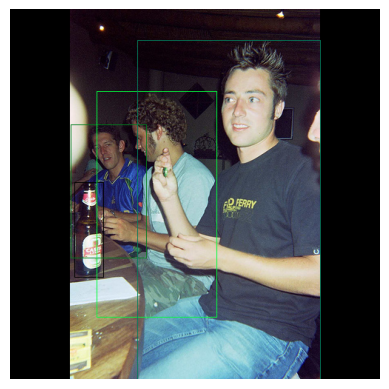

In [59]:
visualize(val_dataset[9][0], val_dataset[9][1]['boxes'], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [61]:
net.eval()
preds = net(val_dataset[9][0].unsqueeze(0))
conf_preds = torch.sigmoid(preds[:, :, :, :, 0])
print(conf_preds.shape)
offset_preds = preds[:, :, :, :, 1:5]
print(offset_preds.shape)
prob_preds = torch.softmax(preds[:, :, :, :, 5:], dim = -1)
print(prob_preds.shape)

torch.Size([1, 16, 16, 5])
torch.Size([1, 16, 16, 5, 4])
torch.Size([1, 16, 16, 5, 20])


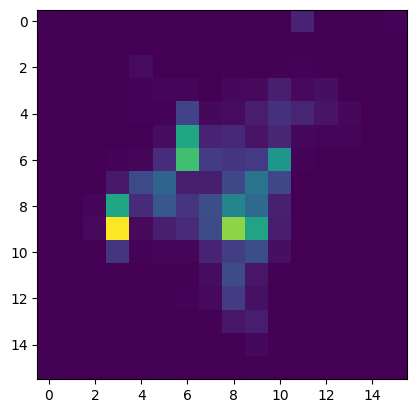

In [62]:
max_conf_preds, max_conf_pred_idxs = torch.max(conf_preds, dim = -1)
plt.imshow(max_conf_preds.squeeze(0).detach().numpy())

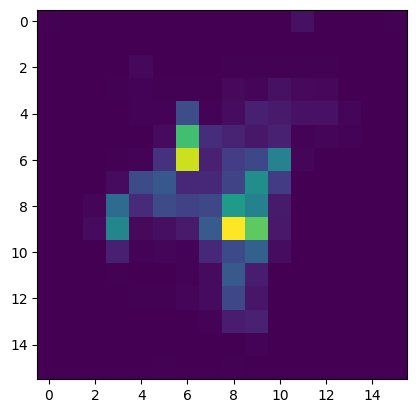

In [63]:
post_prob = max_conf_preds.unsqueeze(3)*prob_preds[:, torch.arange(0, 16), torch.arange(0, 16), max_conf_pred_idxs.squeeze()]
max_post_prob = torch.max(post_prob, dim = -1)[0]
plt.imshow(max_post_prob.squeeze(0).detach().numpy())

In [64]:
post_prob.max()

tensor(0.2732, grad_fn=<MaxBackward1>)

torch.uint8


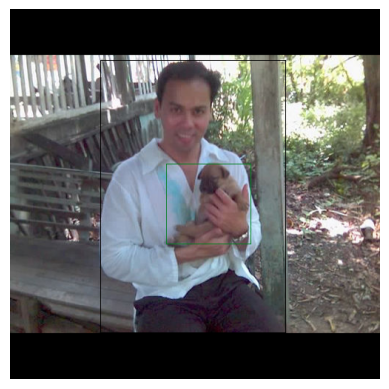

In [65]:
visualize(val_dataset[6][0], val_dataset[6][1]['boxes'], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [122]:
net.eval()
preds = net(val_dataset[6][0].unsqueeze(0))
conf_preds = torch.sigmoid(preds[:, :, :, :, 0])
print(conf_preds.shape)
offset_preds = preds[:, :, :, :, 1:5]
offset_preds[:, :, :, :, :2] = torch.sigmoid(offset_preds[:, :, :, :, :2])
print(offset_preds.shape)
prob_preds = torch.softmax(preds[:, :, :, :, 5:], dim = -1)
print(prob_preds.shape)

torch.Size([1, 16, 16, 5])
torch.Size([1, 16, 16, 5, 4])
torch.Size([1, 16, 16, 5, 20])


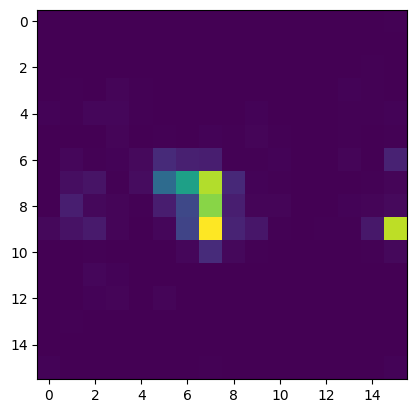

In [123]:
max_conf_preds, max_conf_pred_idxs = torch.max(conf_preds, dim = -1)
plt.imshow(max_conf_preds.squeeze(0).detach().numpy())

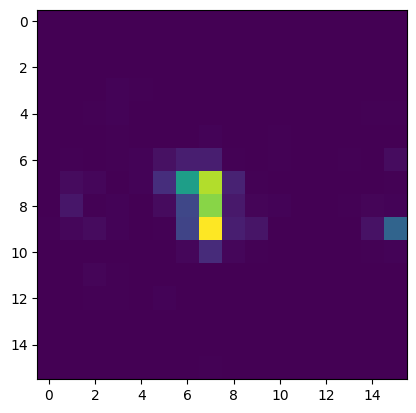

In [124]:
post_prob = max_conf_preds.unsqueeze(3)*prob_preds[:, torch.arange(0, 16), torch.arange(0, 16), max_conf_pred_idxs.squeeze()]
max_post_prob = torch.max(post_prob, dim = -1)[0]
plt.imshow(max_post_prob.squeeze(0).detach().numpy())

In [125]:
post_prob.max()

tensor(0.5886, grad_fn=<MaxBackward1>)

In [126]:
torch.argmax(post_prob, dim = -1)

tensor([[[ 8,  3, 10, 10,  8, 14,  4,  4,  4, 14, 14, 15, 15, 10,  8, 15],
         [ 8,  3,  8, 14,  3, 14,  4,  4,  4, 14, 14, 14, 15,  6,  8, 15],
         [ 8,  3,  8, 14,  3, 14, 14, 14,  4, 14, 14, 14, 15,  6,  8, 15],
         [ 8,  3,  8, 14, 14, 14,  4, 14, 14, 14, 14, 14, 15,  6,  8, 15],
         [ 8,  3,  8, 10, 14, 14, 14, 14,  4, 14, 14, 14, 15,  6,  8, 15],
         [ 8,  8,  8, 10,  8, 14, 14, 14, 14, 14, 14, 14, 15,  6,  8, 15],
         [ 8,  3,  8,  3,  3, 14, 14, 14, 14, 14, 14, 14, 15,  6,  8, 15],
         [ 8,  8,  8,  3,  3, 14, 14, 14, 14, 14, 14, 15, 15,  6,  8, 15],
         [ 8,  8,  8, 14,  3, 14, 14, 14, 14, 14, 14, 15, 10,  6,  8, 15],
         [ 8,  3,  8, 14,  3, 14, 14, 14, 14, 14,  8, 15, 15,  6,  8, 15],
         [14,  3, 10, 14,  3, 14, 14, 14, 14, 14, 14, 15, 15,  6,  8, 15],
         [14,  8, 10, 10, 14, 14, 14, 14, 14, 14, 14, 14, 15,  6,  8, 15],
         [ 8,  8, 10,  8,  8, 14, 14, 14, 14, 14, 14,  1, 15,  6,  8, 15],
         [ 8,  3,  8, 14,

In [127]:
grid_cell_h, grid_cell_w = net.image_size[0]/net.grid_size[0], \
                           net.image_size[1]/net.grid_size[1]

In [128]:
reliable_conf_idxs = torch.where(conf_preds>0.2)
reliable_conf_idxs

(tensor([0, 0, 0, 0, 0, 0]),
 tensor([7, 7, 7, 8, 9, 9]),
 tensor([ 5,  6,  7,  7,  7, 15]),
 tensor([2, 2, 2, 2, 2, 4]))

In [129]:
upper_lefts = torch.cat([reliable_conf_idxs[2].unsqueeze(1), reliable_conf_idxs[1].unsqueeze(1)], dim = 1)*torch.tensor([grid_cell_h, grid_cell_w])
upper_lefts

tensor([[156.2500, 218.7500],
        [187.5000, 218.7500],
        [218.7500, 218.7500],
        [218.7500, 250.0000],
        [218.7500, 281.2500],
        [468.7500, 281.2500]])

In [130]:
anchors = torch.cat([net.anchor_generator(upper_left, grid_cell_h, grid_cell_w) for upper_left in upper_lefts], dim = 0).reshape(-1, net.num_boxes_per_gridcell, 4)
print(anchors.shape)
anchors

torch.Size([6, 5, 4])


tensor([[[171.8750, 234.3750, 127.8012, 127.8012],
         [171.8750, 234.3750, 173.5446, 173.5446],
         [171.8750, 234.3750, 302.6718, 302.6718],
         [171.8750, 234.3750, 414.0100, 414.0100],
         [171.8750, 234.3750,  43.1354,  43.1354]],

        [[203.1250, 234.3750, 127.8012, 127.8012],
         [203.1250, 234.3750, 173.5446, 173.5446],
         [203.1250, 234.3750, 302.6718, 302.6718],
         [203.1250, 234.3750, 414.0100, 414.0100],
         [203.1250, 234.3750,  43.1354,  43.1354]],

        [[234.3750, 234.3750, 127.8012, 127.8012],
         [234.3750, 234.3750, 173.5446, 173.5446],
         [234.3750, 234.3750, 302.6718, 302.6718],
         [234.3750, 234.3750, 414.0100, 414.0100],
         [234.3750, 234.3750,  43.1354,  43.1354]],

        [[234.3750, 265.6250, 127.8012, 127.8012],
         [234.3750, 265.6250, 173.5446, 173.5446],
         [234.3750, 265.6250, 302.6718, 302.6718],
         [234.3750, 265.6250, 414.0100, 414.0100],
         [234.3750, 265.6

In [131]:
reliable_anchors = anchors[torch.arange(0, anchors.shape[0]), reliable_conf_idxs[-1], :]
reliable_anchors

tensor([[171.8750, 234.3750, 302.6718, 302.6718],
        [203.1250, 234.3750, 302.6718, 302.6718],
        [234.3750, 234.3750, 302.6718, 302.6718],
        [234.3750, 265.6250, 302.6718, 302.6718],
        [234.3750, 296.8750, 302.6718, 302.6718],
        [484.3750, 296.8750,  43.1354,  43.1354]])

In [132]:
reliable_offsets = offset_preds[reliable_conf_idxs]
reliable_offsets

tensor([[ 0.7250,  0.6420, -1.5020,  0.4355],
        [ 0.5231,  0.6259, -1.0204,  0.5574],
        [ 0.4146,  0.5395, -1.1831,  0.6868],
        [ 0.3043,  0.1398, -1.1473,  0.7979],
        [ 0.2131,  0.3076, -0.9916, -0.1473],
        [ 0.3653,  0.6269, -3.5630, -0.4692]], grad_fn=<IndexBackward0>)

In [133]:
pred_bboxes = torchvision.ops.box_convert(net.box_coder.decode(reliable_offsets, reliable_anchors, grid_cell_h, grid_cell_w), 'cxcywh', 'xyxy')
pred_bboxes

tensor([[ 66.8399,  73.7016, 290.9731, 403.9203],
        [ 80.4479,  69.1262, 327.2449, 407.4954],
        [112.2576,  61.9909, 351.1521, 409.2294],
        [107.9528,  76.8505, 348.5642, 431.8880],
        [101.2964, 143.9217, 349.5203, 437.8064],
        [469.5899, 281.2059, 490.7420, 320.4779]], grad_fn=<StackBackward0>)

torch.uint8


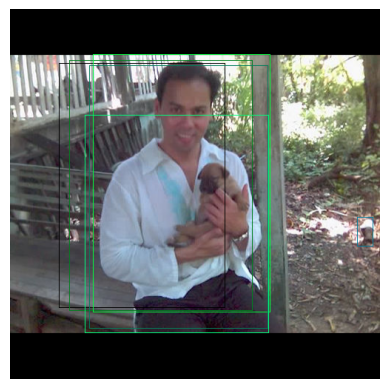

In [134]:
visualize(val_dataset[6][0], pred_bboxes, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [140]:
max_reliable_class_probs, predicted_classes = prob_preds[reliable_conf_idxs].max(dim = -1)
print(max_reliable_class_probs, predicted_classes)

tensor([0.9422, 0.9650, 0.9905, 0.9594, 0.9069, 0.8235],
       grad_fn=<MaxBackward0>) tensor([14, 14, 14, 14, 14, 14])


In [136]:
conf_scores = conf_preds[reliable_conf_idxs]*max_reliable_class_probs
conf_scores

tensor([0.1968, 0.3260, 0.5201, 0.4683, 0.5389, 0.4399],
       grad_fn=<MulBackward0>)

torch.uint8


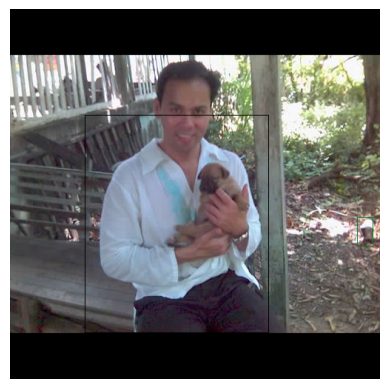

In [137]:
kept_box_idxs = torchvision.ops.nms(pred_bboxes, conf_scores,
                                       iou_threshold = 0.5)
visualize(val_dataset[6][0], pred_bboxes[kept_box_idxs], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [61]:
def predict(model: nn.Module,
            X: torch.Tensor,
            obj_conf_thres: float,
            cls_conf_thres: float,
            nms_thres: float,
            cls_loss_type: Optional[str] = 'CE'):
    """
    cls_loss: "CE"/"ce" or "BCE"/bce. If "CE" was used softmax will be used for inference else sigmoid will be used instead.
    """
    cls_map = {"bce": torch.sigmoid,
               "ce": lambda x: torch.softmax(x, dim = -1)}
    grid_cell_h, grid_cell_w = model.image_size[0]/model.grid_size[0], \
                               model.image_size[1]/model.grid_size[1]
    model.eval()
    preds = model(X.unsqueeze(0))
    ## Split general prediction to different specific prediction
    conf_preds = torch.sigmoid(preds[:, :, :, :, 0])
    offset_preds = preds[:, :, :, :, 1:5]
    offset_preds[:, :, :, :, :2] = torch.sigmoid(offset_preds[:, :, :, :, :2])
    prob_preds = cls_map[cls_loss_type.lower()](preds[:, :, :, :, 5:])
    
    reliable_conf_idxs = torch.where(conf_preds>obj_conf_thres)
    if len(reliable_conf_idxs[0]) == 0:
        pred_clsses, conf_scores, pred_bboxes = [], [], []
    else:
        upper_lefts = torch.cat([reliable_conf_idxs[2].unsqueeze(1), reliable_conf_idxs[1].unsqueeze(1)], dim = 1)*torch.tensor([grid_cell_h, grid_cell_w])
        anchors = torch.cat([model.anchor_generator(upper_left, grid_cell_h, grid_cell_w) for upper_left in upper_lefts], dim = 0).reshape(-1, model.num_boxes_per_gridcell, 4)
        reliable_anchors = anchors[torch.arange(0, anchors.shape[0]), reliable_conf_idxs[-1], :]
        reliable_offsets = offset_preds[reliable_conf_idxs]
        pred_bboxes = torchvision.ops.box_convert(model.box_coder.decode(reliable_offsets, reliable_anchors, grid_cell_h, grid_cell_w), 'cxcywh', 'xyxy')
        max_reliable_class_probs, pred_classes = prob_preds[reliable_conf_idxs].max(dim = -1)
        conf_scores = conf_preds[reliable_conf_idxs]*max_reliable_class_probs
        kept_box_idxs = torchvision.ops.nms(pred_bboxes, conf_scores, iou_threshold = nms_thres)
    
        conf_scores = conf_scores[kept_box_idxs]
        pred_clsses = pred_classes[kept_box_idxs][conf_scores>cls_conf_thres]
        pred_bboxes = pred_bboxes[kept_box_idxs][conf_scores>cls_conf_thres]
        conf_scores = conf_scores[conf_scores>cls_conf_thres]
    return {'class_idxs': pred_clsses,
            'confidence_scores': conf_scores,
            'predicted_boxes': pred_bboxes}

In [40]:
torch.tensor([])

tensor([])

In [18]:
from OD_datasets import VOC_I2N, VOC_N2I

torch.uint8


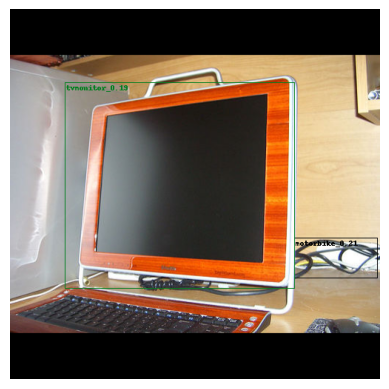

In [80]:
preds = predict(net, val_dataset[4][0], 0.15, 0.15, 0.5)
visualize(val_dataset[4][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


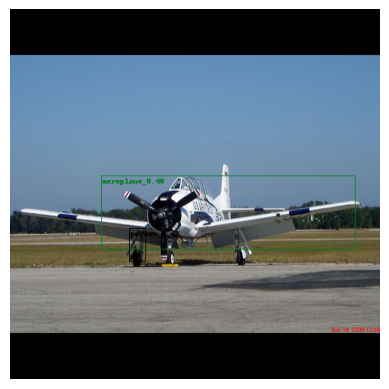

In [81]:
preds = predict(net, val_dataset[5][0], 0.2, 0.2, 0.4)
visualize(val_dataset[5][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


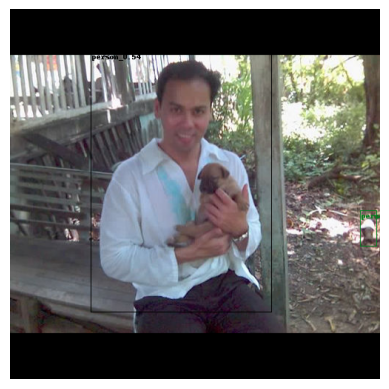

In [82]:
preds = predict(net, val_dataset[6][0], 0.2, 0.2, 0.4)
visualize(val_dataset[6][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


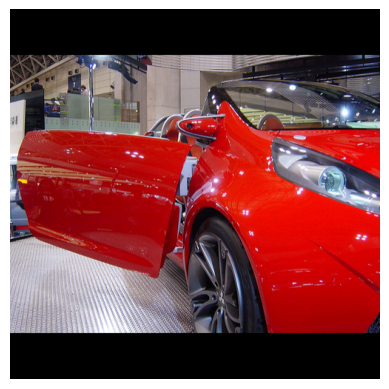

In [84]:
preds = predict(net, val_dataset[7][0], 0.15, 0.15, 0.5)
visualize(val_dataset[7][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


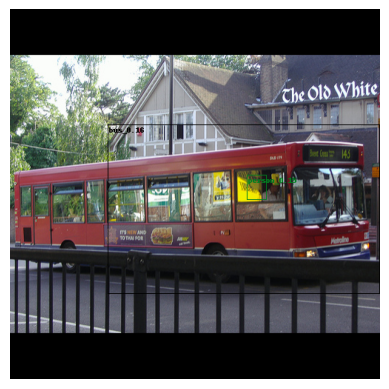

In [86]:
preds = predict(net, val_dataset[8][0], 0.15, 0.15, 0.5)
visualize(val_dataset[8][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


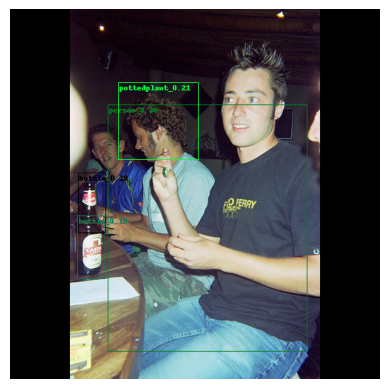

In [88]:
preds = predict(net, val_dataset[9][0], 0.15, 0.15, 0.3)
visualize(val_dataset[9][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


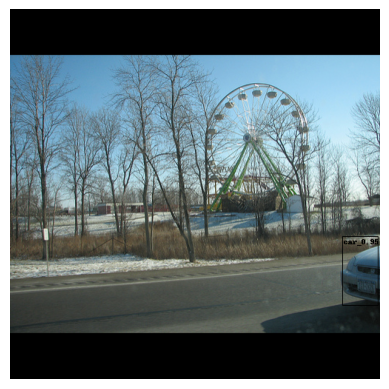

In [89]:
preds = predict(net, val_dataset[10][0], 0.15, 0.15, 0.3)
visualize(val_dataset[10][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


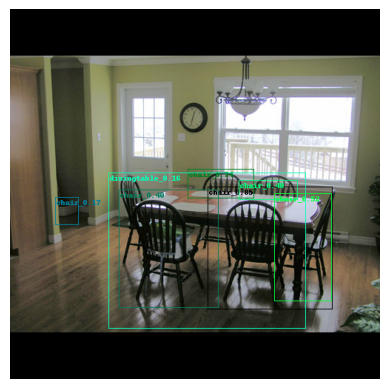

In [91]:
preds = predict(net, val_dataset[11][0], 0.15, 0.15, 0.5)
visualize(val_dataset[11][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


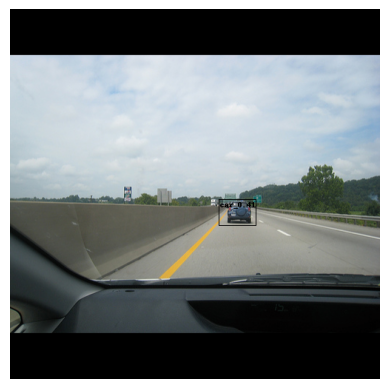

In [92]:
preds = predict(net, val_dataset[12][0], 0.15, 0.15, 0.3)
visualize(val_dataset[12][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


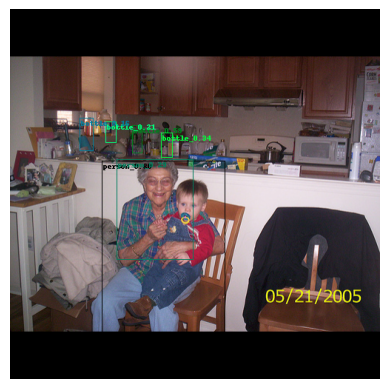

In [94]:
preds = predict(net, val_dataset[13][0], 0.15, 0.15, 0.5)
visualize(val_dataset[13][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


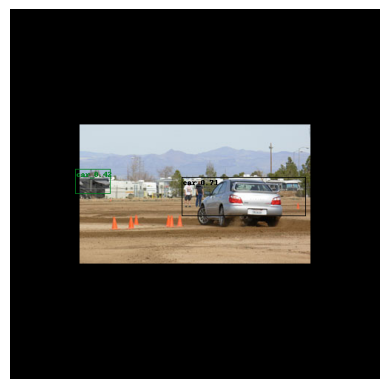

In [95]:
preds = predict(net, val_dataset[14][0], 0.15, 0.15, 0.3)
visualize(val_dataset[14][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


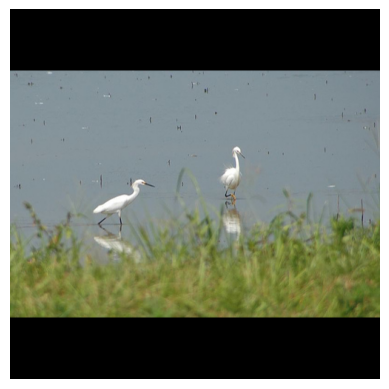

In [99]:
preds = predict(net, val_dataset[15][0], 0.15, 0.15, 0.5)
visualize(val_dataset[15][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


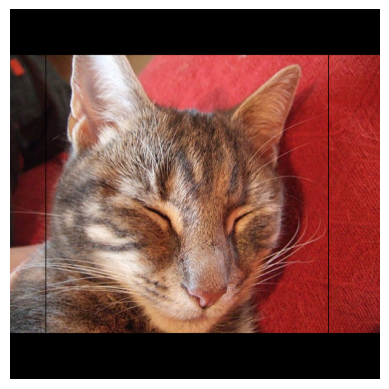

In [100]:
preds = predict(net, val_dataset[16][0], 0.2, 0.15, 0.3)
visualize(val_dataset[16][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


TypeError: list indices must be integers or slices, not tuple

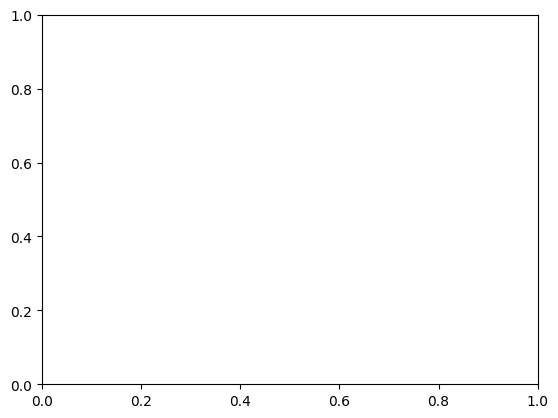

In [101]:
preds = predict(net, val_dataset[17][0], 0.15, 0.15, 0.3)
visualize(val_dataset[17][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


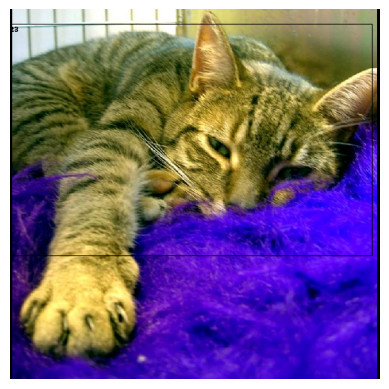

In [102]:
preds = predict(net, val_dataset[18][0], 0.15, 0.15, 0.3)
visualize(val_dataset[18][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


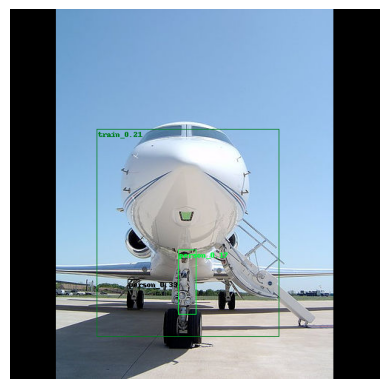

In [103]:
preds = predict(net, val_dataset[19][0], 0.15, 0.15, 0.3)
visualize(val_dataset[19][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


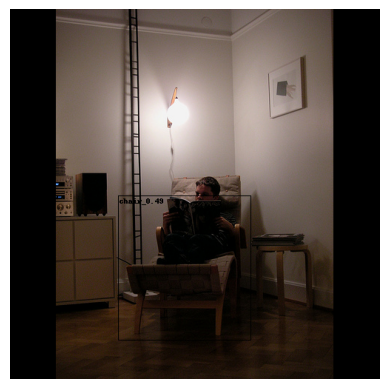

In [105]:
preds = predict(net, val_dataset[20][0], 0.15, 0.15, 0.3)
visualize(val_dataset[20][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


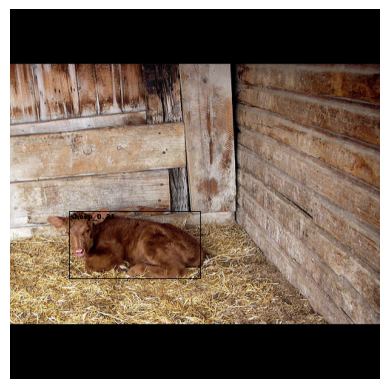

In [106]:
preds = predict(net, val_dataset[21][0], 0.15, 0.15, 0.5)
visualize(val_dataset[21][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


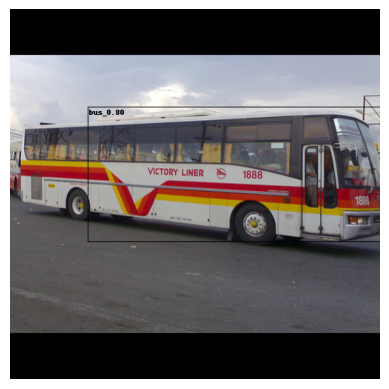

In [107]:
preds = predict(net, val_dataset[22][0], 0.15, 0.15, 0.3)
visualize(val_dataset[22][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

torch.uint8


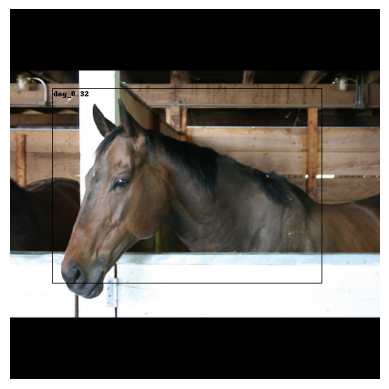

In [108]:
preds = predict(net, val_dataset[23][0], 0.15, 0.15, 0.3)
visualize(val_dataset[23][0], preds['predicted_boxes'], names = [f'{VOC_I2N[cls_idx.item()+1]}_{conf_score:.2f}' for (cls_idx, conf_score) in zip(preds['class_idxs'], preds['confidence_scores'])], mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])